# Heat Exchanger Performance — Analysis Notebook

This version adds:
- Project-aware paths (`data/raw`, `data/processed`, `data/reports`).
- Centralized config cell for **fluid properties** and **time windows**.
- Ambient heat leak correction and **true HX power** & **UA(t)**.
- Integrated summary + CSV exports.
- Self-contained functions (no external imports from your repo needed).

> Sensors: U1 (dewar bottom), U2 (coil top), U3 (dewar top), U4 (coil middle).

In [1]:
# --- Configuration ---
from pathlib import Path

# Heuristic: if running inside HFE_SYSTEM/analysis/notebooks, climb until we see /data and /analysis
NB_PATH = Path.cwd()
REPO_ROOT = NB_PATH
for up in [NB_PATH, *NB_PATH.parents]:
    if (up / "data").exists() and (up / "analysis").exists():
        REPO_ROOT = up
        break

# Input CSVs (change if needed)
RAW_DIR   = REPO_ROOT / "data" / "raw"
NOMIX_CSV = RAW_DIR / "tc_log_20251021_152400-nomix.csv"
MIXED_CSV = RAW_DIR / "tc_log_20251021_142527-mixed1sttest.csv"

# Outputs (will be created if missing)
PROCESSED_DIR = REPO_ROOT / "data" / "processed"
REPORTS_DIR   = REPO_ROOT / "data" / "reports"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# Fluid properties (adjust to your mixture)
rho_kgL      = 1.07   # density [kg/L]
cp_kJkgK     = 3.5    # specific heat [kJ/kg-K]
fill_volumeL = 5.4    # bath volume [L]

# Analysis options
ROLL_WINDOW_S   = 45.0          # smoothing window for dT/dt [s]
EARLY_TMIN0     = 1.0           # early fit window start [min]
EARLY_TMIN1     = 5.0           # early fit window end [min]
EARLY_DT_MIN    = 1.0           # min ΔT for early regression [°C]
EARLY_DT_MAX    = 12.0          # max ΔT for early regression [°C]
SUMMARY_WINDOWS = [(2,6),(6,10),(10,14)]  # reporting windows

In [2]:
# --- Imports & bath capacity ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

rho, cp_kJkgK, V_L = rho_kgL, cp_kJkgK, fill_volumeL
m_kg = rho * V_L
Cp_JK = m_kg * cp_kJkgK * 1000.0
print(f"Repo root: {REPO_ROOT}\nData/raw: {RAW_DIR}\nCp (bath): {Cp_JK:.0f} J/K")

Repo root: /home/pocar-lab/Documents/HFE_System
Data/raw: /home/pocar-lab/Documents/HFE_System/data/raw
Cp (bath): 20223 J/K


In [3]:
# --- Helpers ---
from typing import Tuple

def load_tc_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path).rename(columns={
        "temp1_C":"U1_bottom_C","temp2_C":"U2_coilTop_C",
        "temp3_C":"U3_top_C","temp4_C":"U4_coilMid_C"})
    df["t_min"] = df["time_s"]/60.0
    df["T_bulk_mean_C"] = df[["U1_bottom_C","U3_top_C"]].mean(axis=1)
    df["T_coil_mean_C"] = df[["U2_coilTop_C","U4_coilMid_C"]].mean(axis=1)
    df["DeltaT_C"] = df["T_bulk_mean_C"] - df["T_coil_mean_C"]
    df["Strat_top_minus_bottom_C"] = df["U3_top_C"] - df["U1_bottom_C"]
    return df

def rolling_slope(t_s, y, window_s=45.0, min_pts=5):
    t = np.asarray(t_s); y = np.asarray(y)
    out = np.full(len(t), np.nan)
    half = window_s/2
    for i in range(len(t)):
        t0,t1 = t[i]-half, t[i]+half
        m = (t>=t0) & (t<=t1)
        if np.count_nonzero(m) >= min_pts:
            A = np.vstack([t[m], np.ones(np.count_nonzero(m))]).T
            slope,_ = np.linalg.lstsq(A, y[m], rcond=None)[0]
            out[i] = slope
    return out

def integrate_energy(t_s, power_W):
    return float(np.trapz(np.asarray(power_W), np.asarray(t_s)))

def fit_heat_leak_and_UA(df: pd.DataFrame,
                         tmin0: float, tmin1: float,
                         dTmin: float, dTmax: float) -> Tuple[float,float,float,int]:
    d = df.copy()
    sel = (d["t_min"]>tmin0)&(d["t_min"]<tmin1)&(~d["P_bath_W"].isna())&(d["DeltaT_C"]>dTmin)&(d["DeltaT_C"]<dTmax)
    X = d.loc[sel,["DeltaT_C"]].to_numpy()
    y = d.loc[sel,"P_bath_W"].to_numpy()
    reg = LinearRegression().fit(X,y)
    UA = float(reg.coef_[0]); H = float(-reg.intercept_); R2=float(reg.score(X,y)); N=int(sel.sum())
    return UA,H,R2,N

In [4]:
# --- Load data & compute apparent bath power ---
mixed = load_tc_csv(MIXED_CSV) if MIXED_CSV.exists() else None
nomix = load_tc_csv(NOMIX_CSV)

for d in [nomix, mixed] if mixed is not None else [nomix]:
    d["dTbulk_dt_C_per_s"] = rolling_slope(d["time_s"], d["T_bulk_mean_C"], window_s=ROLL_WINDOW_S)
    d["P_bath_W"] = -Cp_JK * d["dTbulk_dt_C_per_s"]

nomix.head(3)

,time_s,temp0_C,U1_bottom_C,U2_coilTop_C,U3_top_C,U4_coilMid_C,temp5_C,temp6_C,temp7_C,temp8_C,temp9_C,valve,mode,t_min,T_bulk_mean_C,T_coil_mean_C,DeltaT_C,Strat_top_minus_bottom_C,dTbulk_dt_C_per_s,P_bath_W
0,12.053,NaN,9.74,9.66,10.45,9.98,NaN,NaN,NaN,NaN,NaN,1,O,0.200883,10.095,9.820,0.275,0.71,0.000674,-13.621385
1,13.058,NaN,9.74,9.48,10.44,9.93,NaN,NaN,NaN,NaN,NaN,1,O,0.217633,10.090,9.705,0.385,0.70,0.001049,-21.218818
2,14.063,NaN,9.70,9.30,10.43,10.02,NaN,NaN,NaN,NaN,NaN,1,O,0.234383,10.065,9.660,0.405,0.73,0.001056,-21.363639


## Temperatures & stratification (no-mix)

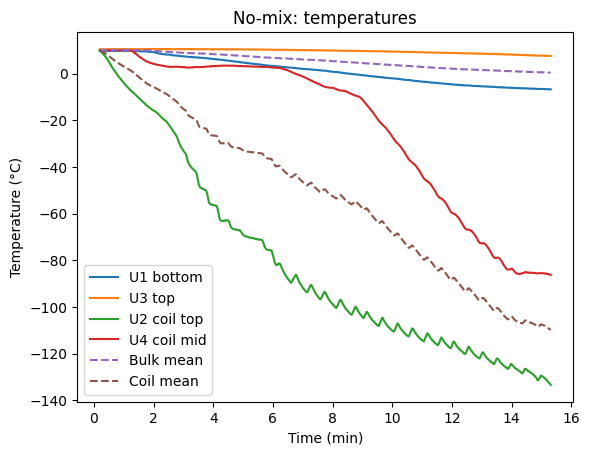

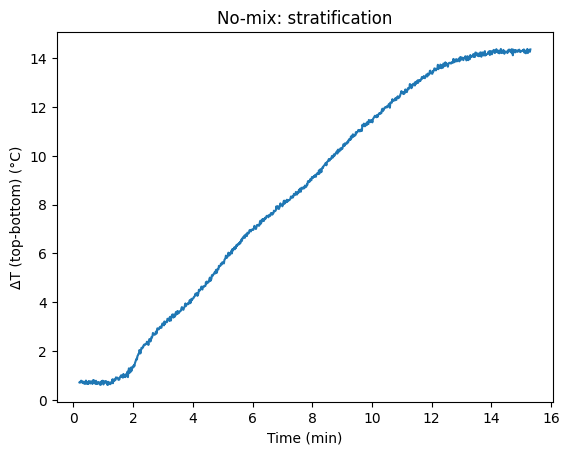

In [5]:
plt.figure()
plt.plot(nomix["t_min"], nomix["U1_bottom_C"], label="U1 bottom")
plt.plot(nomix["t_min"], nomix["U3_top_C"],   label="U3 top")
plt.plot(nomix["t_min"], nomix["U2_coilTop_C"], label="U2 coil top")
plt.plot(nomix["t_min"], nomix["U4_coilMid_C"], label="U4 coil mid")
plt.plot(nomix["t_min"], nomix["T_bulk_mean_C"], linestyle="--", label="Bulk mean")
plt.plot(nomix["t_min"], nomix["T_coil_mean_C"], linestyle="--", label="Coil mean")
plt.xlabel("Time (min)"); plt.ylabel("Temperature (°C)"); plt.title("No-mix: temperatures"); plt.legend(); plt.show()

plt.figure()
plt.plot(nomix["t_min"], nomix["Strat_top_minus_bottom_C"])
plt.xlabel("Time (min)"); plt.ylabel("ΔT (top-bottom) (°C)"); plt.title("No-mix: stratification"); plt.show()

## Estimate ambient heat leak **H** and early **UA**

Early UA = 21.85 W/K, Heat leak H = 144 W, R²=0.976, points=33


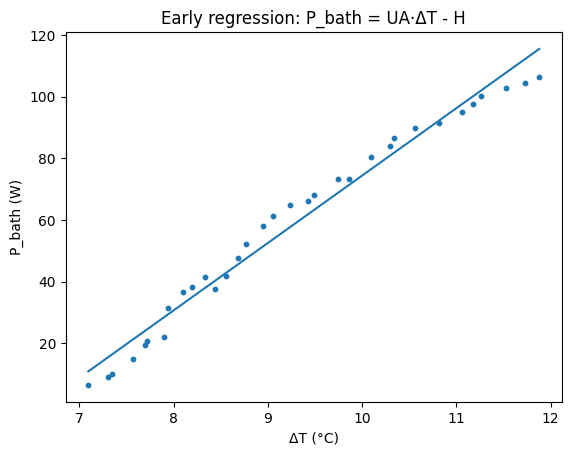

In [6]:
UA_early, H_W, R2, N = fit_heat_leak_and_UA(nomix, EARLY_TMIN0, EARLY_TMIN1, EARLY_DT_MIN, EARLY_DT_MAX)
print(f"Early UA = {UA_early:.2f} W/K, Heat leak H = {H_W:.0f} W, R²={R2:.3f}, points={N}")

early = nomix[(nomix["t_min"]>EARLY_TMIN0)&(nomix["t_min"]<EARLY_TMIN1)&(~nomix["P_bath_W"].isna())&
              (nomix["DeltaT_C"]>EARLY_DT_MIN)&(nomix["DeltaT_C"]<EARLY_DT_MAX)]
plt.figure()
plt.scatter(early["DeltaT_C"], early["P_bath_W"], s=10)
x = np.linspace(early["DeltaT_C"].min(), early["DeltaT_C"].max(), 200)
plt.plot(x, UA_early*x - H_W)
plt.xlabel("ΔT (°C)"); plt.ylabel("P_bath (W)"); plt.title("Early regression: P_bath = UA·ΔT - H"); plt.show()

## Corrected HX power & UA vs time

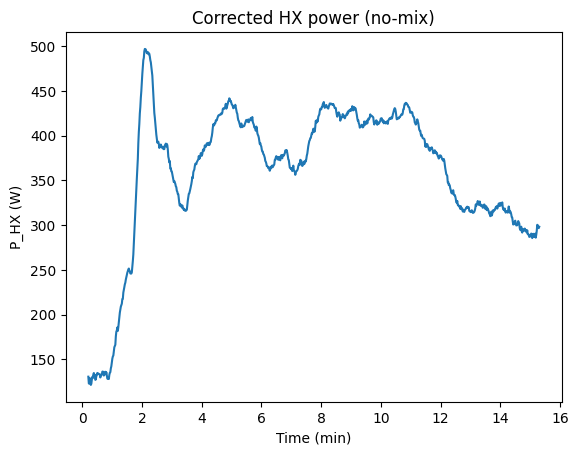

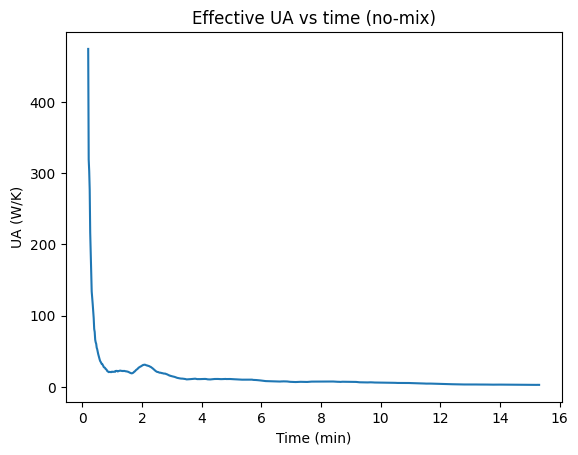

In [7]:
nomix["P_HX_W"] = nomix["P_bath_W"] + H_W
nomix["UA_corr_W_per_K"] = nomix["P_HX_W"] / nomix["DeltaT_C"]

plt.figure(); plt.plot(nomix["t_min"], nomix["P_HX_W"])
plt.xlabel("Time (min)"); plt.ylabel("P_HX (W)"); plt.title("Corrected HX power (no-mix)"); plt.show()

plt.figure(); plt.plot(nomix["t_min"], nomix["UA_corr_W_per_K"])
plt.xlabel("Time (min)"); plt.ylabel("UA (W/K)"); plt.title("Effective UA vs time (no-mix)"); plt.show()

## Windowed medians (power & UA)

In [8]:
def summarize_window(df, t0, t1):
    s = df[(df["t_min"]>=t0)&(df["t_min"]<=t1)&(~df["P_HX_W"].isna())&(df["DeltaT_C"]>0.5)]
    if len(s)==0:
        return {"window": f"{t0}–{t1}","P_med_W":np.nan,"P_10_W":np.nan,"P_90_W":np.nan,
                "UA_med_WK":np.nan,"UA_10_WK":np.nan,"UA_90_WK":np.nan,"N":0}
    Pmed = float(np.nanmedian(s["P_HX_W"])); P10,P90 = np.nanpercentile(s["P_HX_W"],[10,90])
    UAmed = float(np.nanmedian(s["UA_corr_W_per_K"])); UA10,UA90 = np.nanpercentile(s["UA_corr_W_per_K"].dropna(),[10,90])
    return {"window":f"{t0}–{t1}","P_med_W":round(Pmed,1),"P_10_W":round(P10,1),"P_90_W":round(P90,1),
            "UA_med_WK":round(UAmed,2),"UA_10_WK":round(UA10,2),"UA_90_WK":round(UA90,2),"N":len(s)}

summary_df = pd.DataFrame([summarize_window(nomix, *w) for w in SUMMARY_WINDOWS])
summary_df

,window,P_med_W,P_10_W,P_90_W,UA_med_WK,UA_10_WK,UA_90_WK,N
0,2–6,401.2,337.0,441.1,10.94,10.01,23.90,239
1,6–10,412.6,365.3,431.9,7.03,6.17,7.65,239
2,10–14,376.2,316.4,425.6,4.17,3.10,5.60,238


## Net energy removed by the HX (ambient-corrected)

In [9]:
sel = (nomix["t_min"]>=2)&(nomix["t_min"]<=14)&(~nomix["P_HX_W"].isna())
E_HX_kJ = integrate_energy(nomix.loc[sel,"time_s"], nomix.loc[sel,"P_HX_W"])/1000.0
print(f"Integrated HX energy 2–14 min: {E_HX_kJ:.0f} kJ")

Integrated HX energy 2–14 min: 280 kJ


/tmp/ipykernel_20239/47666262.py:29: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(np.asarray(power_W), np.asarray(t_s)))


## Mixed vs no-mix (stratification)

Mixed: ΔT(top-bottom) median = 0.18 °C (10–90% -1.42–0.34)
No-mix: ΔT(top-bottom) median = 8.72 °C (10–90% 1.00–14.19)


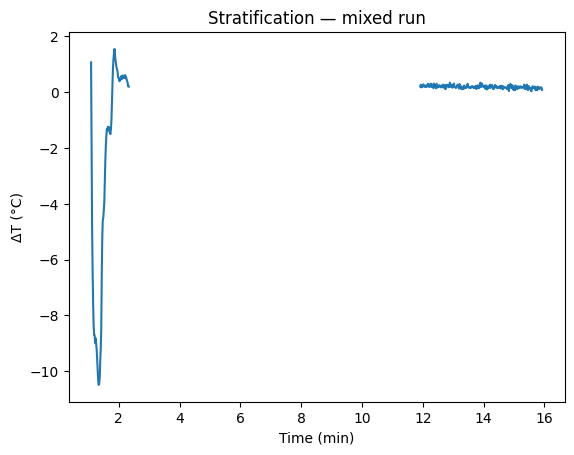

In [10]:
if MIXED_CSV.exists():
    mixed = load_tc_csv(MIXED_CSV)
    def strat_stats(df, label):
        vals = df["Strat_top_minus_bottom_C"].dropna().to_numpy()
        med = float(np.nanmedian(vals)); q10,q90 = np.nanpercentile(vals,[10,90])
        print(f"{label}: ΔT(top-bottom) median = {med:.2f} °C (10–90% {q10:.2f}–{q90:.2f})")
    strat_stats(mixed, "Mixed")
    strat_stats(nomix, "No-mix")
    plt.figure(); plt.plot(mixed["t_min"], mixed["Strat_top_minus_bottom_C"])
    plt.xlabel("Time (min)"); plt.ylabel("ΔT (°C)"); plt.title("Stratification — mixed run"); plt.show()
else:
    print("Mixed file not found; skipping.")

## Export results

In [11]:
timeseries_out = PROCESSED_DIR / "hx_timeseries_corrected.csv"
summary_out    = REPORTS_DIR   / "hx_summary_windows.csv"
params_out     = REPORTS_DIR   / "hx_fit_params.txt"

ts = nomix[["time_s","t_min","T_bulk_mean_C","T_coil_mean_C","DeltaT_C","P_bath_W","P_HX_W","UA_corr_W_per_K"]]
ts.to_csv(timeseries_out, index=False)
summary_df.to_csv(summary_out, index=False)
with open(params_out,"w") as f:
    f.write(f"UA_early_WK: {UA_early:.3f}\n")
    f.write(f"H_W: {H_W:.1f}\n")
    f.write(f"R2: {R2:.3f}\n")
    f.write(f"Cp_JK: {Cp_JK:.1f}\n")
    f.write(f"Volume_L: {V_L}\n")
print("Saved:", timeseries_out) ; print("Saved:", summary_out) ; print("Saved:", params_out)

Saved: /home/pocar-lab/Documents/HFE_System/data/processed/hx_timeseries_corrected.csv
Saved: /home/pocar-lab/Documents/HFE_System/data/reports/hx_summary_windows.csv
Saved: /home/pocar-lab/Documents/HFE_System/data/reports/hx_fit_params.txt
